
# Who will leave the work?

The project concerns predicting who of the people in data science will change the job. The analysis included tabular data describing the nature of employees and a column with a target specifying whether the employee left work. In the project, I will try to clean the data by filling in missing data, changing categorical data to numerical data and then creating a model for prediction.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy

## Chapter 1: Data Load

In [87]:
df = pd.read_csv('Data/aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Chapter 2:  EDA

In [88]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [89]:
print(f'The number of rows: {len(df.axes[0])}')

The number of rows: 19158


In [90]:
print(f'The number of columns: {len(df.axes[1])}')

The number of columns: 14


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

After checking the main information about the data, I will have to work with a large amount of missing data and apply the method of changing text data to numeric data to each column accordingly.

In [92]:
nulls_summary = pd.DataFrame(df.isnull().any(), columns=['Nulls'])
nulls_summary['Num_of_nulls [qty]'] = pd.DataFrame(df.isnull().sum())
nulls_summary['Num_of_nulls [%]'] = round((df.isnull().mean()*100),2)
nulls_summary

,Nulls,Num_of_nulls [qty],Num_of_nulls [%]
enrollee_id,False,0,0.00
city,False,0,0.00
city_development_index,False,0,0.00
gender,True,4508,23.53
relevent_experience,False,0,0.00
enrolled_university,True,386,2.01
education_level,True,460,2.40
major_discipline,True,2813,14.68
experience,True,65,0.34
company_size,True,5938,30.99


I assume that emplyee_id is an individual employee number that was randomly assigned and does not provide information about the attributes of a given person. Therefore, I decide to remove this feature at this stage to avoid information noise in subsequent analyses.

In [93]:
df = df.drop(columns=['enrollee_id'])

In [94]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


In [95]:
df.describe(include='object')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


After analyzing the describe function, at this stage I already know that I will have to organize the data, especially using mapping, one encoder and cleaning strings that contain numbers with special characters around.

### Correlation between numerical variables

I start by checking the correlation between numerical values, and in order to choose the appropriate correlation method, I first check whether the data comes from a normal distribution.

In [96]:
# Test for normality of distribution
# Assumed significance level alpha = 0.05.
if(scipy.stats.normaltest(df['city_development_index'])[1] < 0.05):
    print('I reject the null hypothesis and accept the alternative hypothesis: the variable does not come from a normal distribution.')
else:
    print('I accept the null hypothesis. The variable comes from a normal distribution.')

I reject the null hypothesis and accept the alternative hypothesis: the variable does not come from a normal distribution.


The data does not come from a normal distribution, so I cannot use Pearson correlation, so I choose the Spearman method.

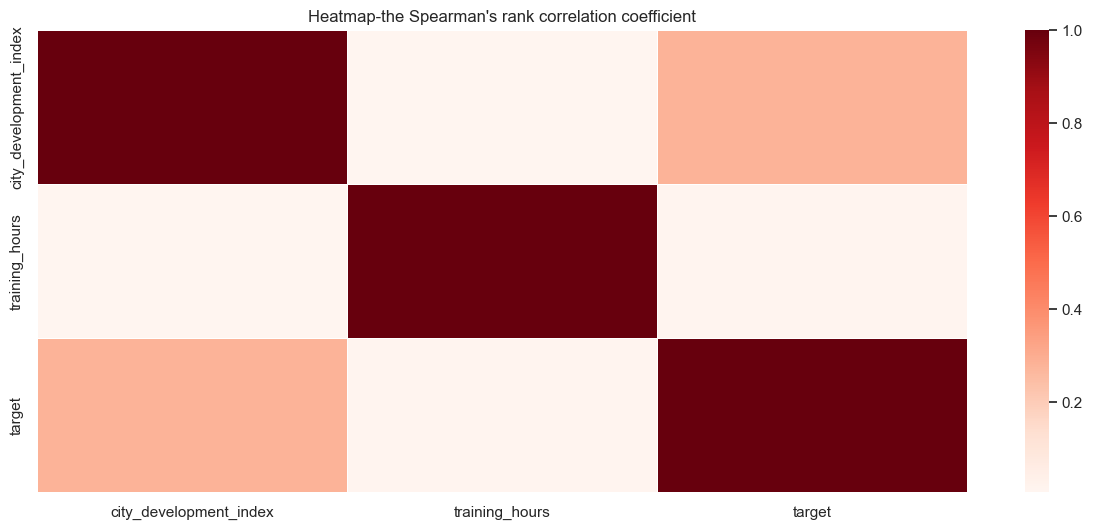

In [97]:
import scipy
corr_num = pd.DataFrame(scipy.stats.spearmanr(df.select_dtypes(include = ['float', 'int']))[0],
                        columns = df.select_dtypes(include = ['float', 'int']).columns,
                        index = df.select_dtypes(include = ['float', 'int']).columns)

plt.figure(figsize=(15,6))
sns.set(font_scale=1)
sns.heatmap(corr_num.abs(), cmap="Reds", linewidths=.5).set(title="Heatmap-the Spearman's rank correlation coefficient")
plt.show()

The presented heat map shows no correlation between target and training ours and moderate correlation with city development index, which allows us to determine that we can use both features when constructing the model. Different levels of feature correlation should be properly captured by the future model.

### Correlation between numerical and categorical variables

In the next stage I analyze the correlation between numerical and categorical data, I have already noticed that the relationship between the city and the city development index may have a high correlation, in the further part of the project I will check if both columns are repeated.

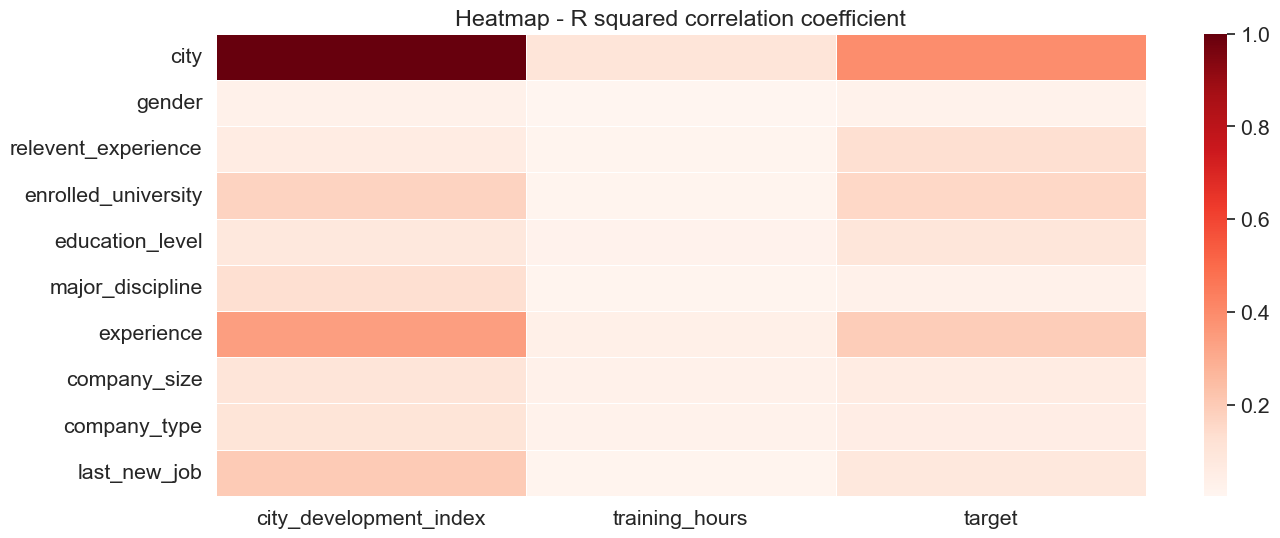

In [98]:
import statsmodels.formula.api as sm
cat_cols = ['city', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job']
num_cols = df.drop(cat_cols, axis = 1).columns


cols = []
for cat in cat_cols:
    rows = []
    for num in num_cols:
        formula = num + '~' +cat
        model = sm.ols(formula=formula,data=df)
        rows.append(np.sqrt(model.fit().rsquared))
    cols.append(rows)
corr_num_cat = pd.DataFrame(cols, index = cat_cols, columns = num_cols)

# wykres zależności
plt.figure(figsize=(15,6))
sns.set(font_scale=1.4)
sns.heatmap(corr_num_cat, cmap="Reds", linewidths=.5).set(title='Heatmap - R squared correlation coefficient')
plt.show()

### Correlation between categorical variables

The correlation between categorical data is low or medium. This means that I can use all of these features in the model because none of them will be duplicated.

In [99]:
def CramersV(tab):
    a = scipy.stats.chi2_contingency(tab)[0]/sum(tab.sum())
    b = min(tab.shape[0]-1, tab.shape[1]-1,)
    return(np.sqrt(a/b))

def CalculateCrammersV(tab):
    ret = []
    for m in tab:
        row = []
        for n in tab:
            cross_tab = pd.crosstab(tab[m].values,tab[n].values)
            row.append(CramersV(cross_tab))
        ret.append(row)
    return pd.DataFrame(ret, columns=tab.columns, index=tab.columns)

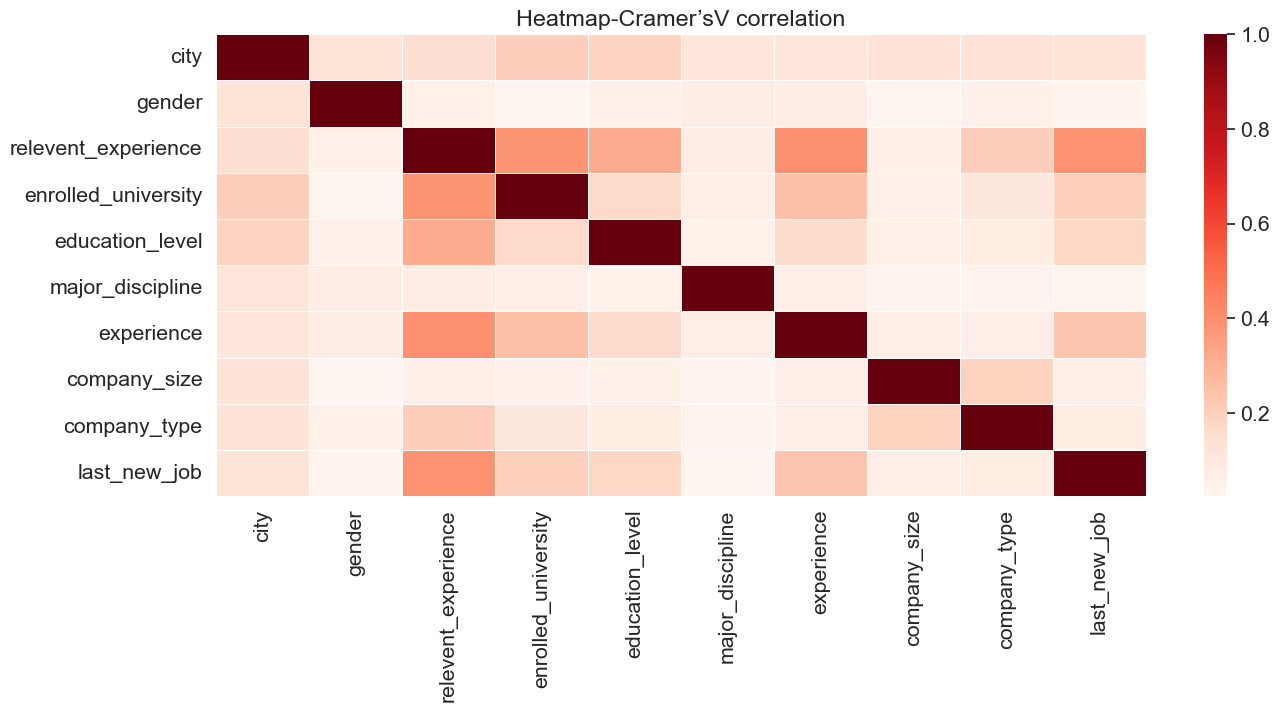

In [100]:
crammer = CalculateCrammersV(df[cat_cols])

plt.figure(figsize=(15,6))
sns.set(font_scale=1.4)
sns.heatmap(crammer, cmap="Reds", linewidths=.5).set(title='Heatmap-Cramer’sV correlation')
plt.show()

# Chapter 3:  Features transformation

### 1. enrollee_id
- Unique ID for enrollee, it is typicaly random number gien to employee which is meaningless about the characteristic of person
- It leads to the conlusion that it can have negative impoact on model, so best practive is drop variable, as I done in the biggening

### 2&3. city &  city_development_index
- city: City code
- city_development_index: Developement index of the city (scaled)
- the varibales seems to be duplicated so I removed city, as city_development_index is already numerical and scaled

In [101]:
df[(df["city"]=="city_103")][['city', 'city_development_index']]

,city,city_development_index
0,city_103,0.92
8,city_103,0.92
9,city_103,0.92
11,city_103,0.92
16,city_103,0.92
...,...,...
19146,city_103,0.92
19149,city_103,0.92
19152,city_103,0.92
19154,city_103,0.92


In [102]:
df_compare = df.groupby('city')['city_development_index'].agg(['min', 'max'])
df_compare_result = df_compare[(df_compare['min'] != df_compare['max'])]
df_compare_result

,min,max
city,,


In [103]:
df = df.drop(columns=['city'])

### 4. gender
- Gender of enrolee
- There is 3 Categories of gender: Male, Female and Other
- Cleanining data by full filling missing values with 'Male' duto to highest frequency
- Using get_dummies to convert data into numeric

In [104]:
df['gender'].value_counts()

gender
Male      13221
Female     1238
Other       191
Name: count, dtype: int64

In [105]:
df['gender'].mode()[0]

'Male'

In [106]:
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

df = pd.get_dummies(df, columns=['gender'], drop_first=False, dtype=int)
    

### 5. relevent_experience
- Relevent experience of enrolee
- No missing values, so cleaning data by mapping 'Has relevent experience': 1, 'No relevent experience': 0

In [107]:
df['relevent_experience'].value_counts()

relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64

In [108]:
experience = {'Has relevent experience': 1, 'No relevent experience': 0}
df['relevent_experience']= df['relevent_experience'].map(experience)

### 6. enrolled_university
- Type of University course enrolled if any
- Cleanining data by full filling missing values with 'no_enrollment' and using mapping
'no_enrollment': 0, 'Part time course': 1, 'Full time course': 2
- I considered using one hot encoder, but during the design and future importance analysis, it turned out that enrolled_university had very little impact on the decision tree that was created.

In [109]:
df['enrolled_university'].value_counts()

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64

In [110]:
df['enrolled_university'] = df['enrolled_university'].fillna('no_enrollment')
enrolled_uni = {'no_enrollment': 0, 'Part time course': 1, 'Full time course': 2}
df['enrolled_university']= df['enrolled_university'].map(enrolled_uni)

### 7. education_level
- Education level of enrolee
- Cleanining data by full filling missing values with 'other' and using mapping: 'Other':0, 'Primary School':1, 'High School':2, 'Graduate':3, 'Masters':4, 'Phd':5
- mapping was created based on school graduation level

In [111]:
df['education_level'].value_counts()

education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64

In [112]:
df['education_level'] = df['education_level'].fillna('Other')
education = {'Graduate':3, 'Masters':4, 'High School':2, 'Other':0, 'Phd':5, 'Primary School':1}
df['education_level']= df['education_level'].map(education)

### 8. major_discipline
- Education major discipline of enrolee
- Cleanining data by full filling missing values with 'No Major' and Labels Encoder
- In the first approach, I changed the major_disciplines with one hot encoding. However, all disciplines were included as those that have the least impact on the model. That is why I chose the encoder label method in order not to expand the table with additional columns.

In [113]:
df['major_discipline'].value_counts()

major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64

In [114]:
from sklearn.preprocessing import LabelEncoder
df['major_discipline'] = df['major_discipline'].fillna('No Major')
le = LabelEncoder()
df['major_discipline'] = le.fit_transform(df['major_discipline'])

### 9. experience
- Enrolee total experience in years
- cleaning all chars which are not numbers, full filling missing as '0' and changing variables into float type

In [115]:
df['experience'].value_counts()

experience
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: count, dtype: int64

In [116]:
df['experience'] = df['experience'].str.replace('>20', '21')
df['experience'] = df['experience'].str.replace('<1', '0.5')
df['experience'] = df['experience'].fillna(0).astype('float')

### 10. company_size
- No of employees in current employer's company
- Cleanining data by full filling missing values with 'other' and using mapping: 'Other':0, '<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-9999':7, '10000+':8 - by company size

In [117]:
df['company_size'].value_counts(normalize=True)

company_size
50-99        0.233207
100-500      0.194478
10000+       0.152723
10/49        0.111271
1000-4999    0.100454
<10          0.098941
500-999      0.066339
5000-9999    0.042587
Name: proportion, dtype: float64

In [118]:
df['company_size'] = df['company_size'].fillna('Other')
size = {'Other':0, '<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-9999':7, '10000+':8}
df['company_size']= df['company_size'].map(size)

### 11.company_type
- Type of current employer
- Cleanining data by full filling missing values with 'Pvt Ltd' duto to highest frequency and using get_dummies

In [119]:
df['company_type'].value_counts(normalize=True)

company_type
Pvt Ltd                0.754110
Funded Startup         0.076894
Public Sector          0.073360
Early Stage Startup    0.046320
NGO                    0.040022
Other                  0.009295
Name: proportion, dtype: float64

In [120]:
df['company_type'] = df['company_type'].fillna(df['company_type'].mode()[0])
df = pd.get_dummies(df, columns=['company_type'], drop_first=False, dtype=int)

### 12. last_new_job
- Difference in years between previous job and current job
- cleaning all chars which are not numbers, full filling missing as mean and changing variables into float type

In [121]:
df['last_new_job'].value_counts(normalize=True)

last_new_job
1        0.429143
>4       0.175607
2        0.154790
never    0.130878
4        0.054924
3        0.054657
Name: proportion, dtype: float64

In [122]:
df['last_new_job'] = df['last_new_job'].str.replace('>4', '5')
df['last_new_job'] = df['last_new_job'].str.replace('never', '0')
df['last_new_job'] = df['last_new_job'].astype('float')
df['last_new_job'] = df['last_new_job'].fillna(df['last_new_job'].mean())

### 13. training_hours
- training hours completed
- no need for cleaning

In [123]:
df['training_hours'].value_counts()

training_hours
28     329
12     292
18     291
22     282
50     279
      ... 
266      6
234      5
272      5
286      5
238      4
Name: count, Length: 241, dtype: int64

# Missing check

In [124]:
print("Any missing sample in training set:",df.isnull().values.any())

Any missing sample in training set: False


## Train test split
Dividing the data into training and testing parts as in next step the training set will be resampled to increase the records of minority class

In [125]:
from sklearn.model_selection import  train_test_split

In [126]:
y = df['target']
X = df.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### 14. target:
 - 0 – Not looking for job change, 
 - 1 – Looking for a job change
 - The target variable is not distributed equably, so I use resampling to increase the smaller class

In [127]:
df['target'].value_counts()

target
0.0    14381
1.0     4777
Name: count, dtype: int64

In [128]:
df_train = pd.concat([X_train, y_train], axis = 1) 
df_train['target'].value_counts()

target
0.0    10066
1.0     3344
Name: count, dtype: int64

In [129]:
from sklearn.utils import resample

df_train = pd.concat([X_train, y_train], axis = 1)       

df_majority = df_train[df_train['target'] == 0]
df_minority = df_train[df_train['target'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=10066,    # to match majority class
                                 random_state=42) # reproducible results
 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])       

In [130]:
df_upsampled['target'].value_counts()

target
0.0    10066
1.0    10066
Name: count, dtype: int64

## Train test split of upsampled df

In [131]:
y = df_upsampled['target']
X = df_upsampled.drop(columns=['target'])
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Feature importances

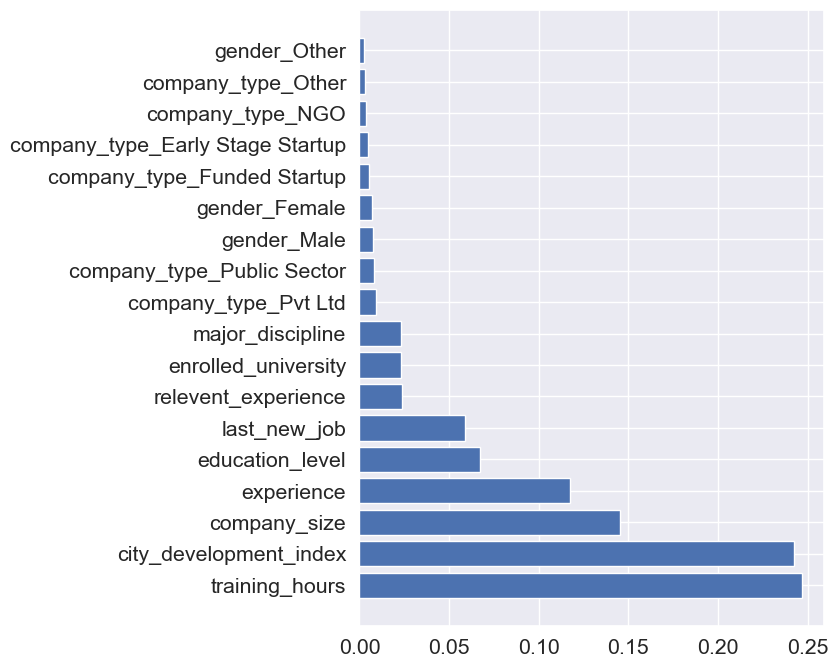

In [132]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train_up, y_train_up)

feature_importances = dict(zip(model.feature_names_in_, model.feature_importances_))
feature_importances = pd.Series(feature_importances).sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 8))
plt.barh(feature_importances.index, feature_importances.values)
plt.show()

Using the decision tree model and the futures importances function I investigate which transformation has the greatest impact on the model. In previous changes I often used encoding but I noticed that it causes a lot of features with minimal importance on the model. That is why I often decide to use mapping or label encoder and I think that the weights of the current features should create the best model result

# Chapter 4: Modeling

I choose Tree-Based Algorithms becouse the data contains plenty of categorical variables. I decided not to use logistic regression because in the previous attempt after rescaling the data the model achieved a very low result. The data on which the model is trained is not suitable for logistic regression because it almost does not contain continuous numerical features.

In [133]:
from sklearn.metrics import f1_score

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample

In [134]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGB": xgb.XGBClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose = False, random_state=42)
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_metrics = []
result = []

for model in models.values():
    for train_index, test_index in kf.split(df):
        cv_train, cv_test = df.iloc[train_index],df.iloc[test_index]
        
        df_train = pd.concat([X_train, y_train], axis = 1)    
        df_majority = cv_train[cv_train['target'] == 0]
        df_minority = cv_train[cv_train['target'] == 1]

        df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=42) # reproducible results
 
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])    
    
        cv_train_X = df_upsampled.drop("target", axis=1).values
        cv_train_y = df_upsampled["target"].values
    
        cv_test_X = cv_test.drop("target", axis=1).values
        cv_test_y = cv_test["target"].values
    
        model.fit(cv_train_X,cv_train_y)
        predictions = model.predict(cv_test_X)
        metric = f1_score(cv_test_y,predictions)
        fold_metrics.append(metric)
    result.append(fold_metrics)
    fold_metrics = []

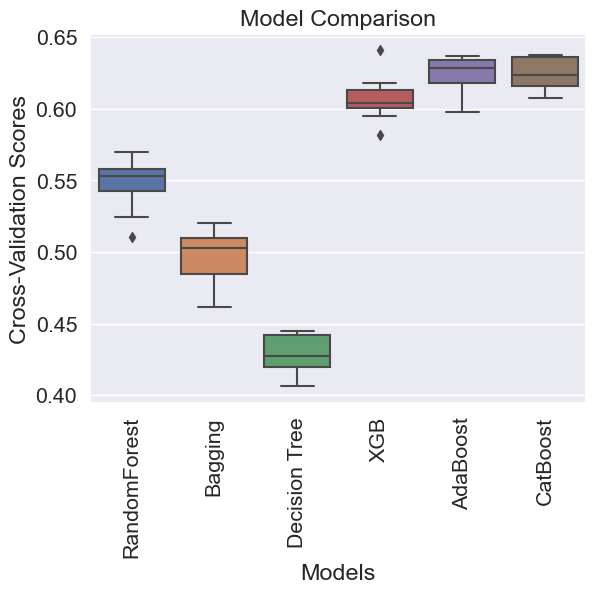

In [135]:
sns.boxplot(data=result)
plt.xticks(ticks=range(len(models)), labels=models.keys(), rotation=90)
plt.ylabel("Cross-Validation Scores")
plt.xlabel("Models")
plt.title("Model Comparison")
plt.show()

The best result was achieved by the model on Radome Forest, so in the next part I will investigate which parameters are best to use.

In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division = 0)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total    

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')

In addition, I check how neural network models work on tabular data, usually much better results are obtained using learning machines, and it is the same in this case.

In [137]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

clf_model = MLPClassifier(
    hidden_layer_sizes=(8, 10, 4),
    activation='relu',
    solver='adam',
    max_iter=1000,
    batch_size=32,
    random_state=42
)

clf_model.fit(X_train_up, y_train_up)
y_pred = clf_model.predict(X_test)
print_results(calculate_metrics(y_test, y_pred),classifier_id='MLPClassifier')

Results for MLPClassifier
----
  Accuracy:  0.7310368823938761
  Precision: 0.6889316431663006
  Recall:    0.742554858617313
  F1 score:  0.6936507323638348
  Mislabeled 1546 out of 5748


In [138]:
from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
    

best_model = GridSearchCV(model, param_grid=param_grid, cv=kf, scoring = 'f1_micro')
best_model.fit(X_train_up, y_train_up)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     int...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='f1_micro')

In [139]:
best_lr = best_model.best_estimator_
best_params = best_model.best_params_
# coefs = best_model.coef_
print(best_lr, best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}


In [140]:
model = xgb.XGBClassifier(min_child_weight=1, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
        max_depth = 5, random_state=42)
model.fit(X_train_up, y_train_up)
y_pred = model.predict(X_test)
print_results(calculate_metrics(y_test, y_pred),classifier_id='xgb.XGBClassifier')

Results for xgb.XGBClassifier
----
  Accuracy:  0.7785316631871956
  Precision: 0.7204134022219781
  Recall:    0.7634686931693673
  F1 score:  0.7330303602457278
  Mislabeled 1273 out of 5748


In [141]:
resultss = pd.DataFrame(best_model.cv_results_)
resultss.sort_values(by='rank_test_score', inplace=True)
params_2nd_best = resultss.iloc[2]['params']
clf_2nd_best = best_model.best_estimator_.set_params(**params_2nd_best)
resultss[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
154,0.628259,0.111961,0.023403,0.004804,0.8,0.5,5,1,0.8,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_d...",0.803831,0.788932,0.811923,0.797729,0.800568,0.800597,0.007524,1
289,0.346129,0.043906,0.017372,0.001090,1.0,0.5,5,1,0.8,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_d...",0.807024,0.790351,0.810859,0.789922,0.804826,0.800596,0.008757,2
316,0.305087,0.008040,0.017001,0.000634,1.0,1,5,1,0.8,"{'colsample_bytree': 1.0, 'gamma': 1, 'max_dep...",0.801348,0.792480,0.805536,0.790987,0.806955,0.799461,0.006591,3
288,0.320353,0.007883,0.017600,0.001019,1.0,0.5,5,1,0.6,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_d...",0.800639,0.790706,0.808730,0.794535,0.800568,0.799035,0.006140,4
153,0.487890,0.019614,0.019426,0.001707,0.8,0.5,5,1,0.6,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_d...",0.799220,0.794608,0.811214,0.789212,0.799858,0.798822,0.007279,5
181,0.426500,0.015632,0.019804,0.002319,0.8,1,5,1,0.8,"{'colsample_bytree': 0.8, 'gamma': 1, 'max_dep...",0.807379,0.787868,0.808730,0.786373,0.803407,0.798751,0.009668,6
180,0.484350,0.038571,0.020001,0.002094,0.8,1,5,1,0.6,"{'colsample_bytree': 0.8, 'gamma': 1, 'max_dep...",0.800639,0.782902,0.812988,0.791341,0.797374,0.797049,0.009998,7
292,0.337834,0.036924,0.020301,0.002224,1.0,0.5,5,5,0.8,"{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_d...",0.792125,0.789287,0.814053,0.786018,0.797374,0.795771,0.009872,8
342,0.513971,0.371688,0.020324,0.004095,1.0,1.5,5,1,0.6,"{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_d...",0.803476,0.776162,0.809439,0.791341,0.797729,0.795630,0.011437,9
315,0.321833,0.006836,0.017057,0.000067,1.0,1,5,1,0.6,"{'colsample_bytree': 1.0, 'gamma': 1, 'max_dep...",0.793189,0.780419,0.809794,0.787438,0.805536,0.795275,0.010978,10


Comparison of cross-validation results showed that the most effective models were XGboost, Adaboost and Catboost. I tested them in gridsearch. Xgboost gave a satisfactory result. By comparing the top 10 xgboost results, we can conclude that the selected parameters will allow us to achieve the highest prediction results. I used the F1 score formula for testing, because it considers both how good the model is at finding the right things and how good it is at avoiding mistakes.